import libraries

In [1]:
import tensorflow as tf  # Only used as a asource of MNIST data
import requests
import numpy as np
import matplotlib.pyplot as plt

Get MNIST data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Select random image from the test part of MNIST

Text(0.5, 1.0, "Digit '9'")

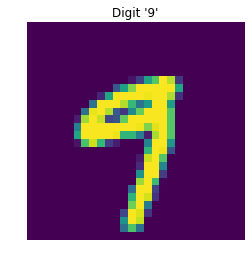

In [3]:
idx = np.random.choice(range(x_test.shape[0]))
x = x_test[idx]
plt.imshow(x)
plt.axis('off')
plt.title(f"Digit '{y_test[idx]}'")

Specify the inference link to the hydrosphere.io

In [4]:
service_link = "https://dev.k8s.hydrosphere.io/gateway/application/mnist-app"

Check the inference service

In [5]:
response = requests.post(url=service_link, json={"imgs": [x.tolist()]})
predicted_probas = np.array(response.json()["probabilities"])
f"Predicted label is {predicted_probas.argmax()}"

KeyError: 'probabilities'

In [6]:
response.json()

{'error': 'NotFound',
 'information': "Can't find application with name mnist-app"}

Specify the link to the RISE image interpretability service

In [6]:
rise_link = "http://0.0.0.0:5000/rise" 

In [8]:
rise_config = {"number_of_masks":300,
               "mask_granularity":3,
               "mask_density":0.4,
               "input_size": [28,28],
               "single_channel": True,
               }

In [11]:
response = requests.post(url=rise_link, json={"image": x.tolist(),
                                              "config": rise_config,
                                              "application_name":"mnist-app"})  # Send image in json
saliency_maps  = np.array(response.json())  # Response contains multiple saliency maps - one for each class

The result cllection of masks is of shape (number of classes; width; height). It contains a sailency map for each output class.

In [12]:
saliency_maps.shape

(10, 28, 28)

Check the predicted probabilities again

In [13]:
predicted_probas

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Visualize results

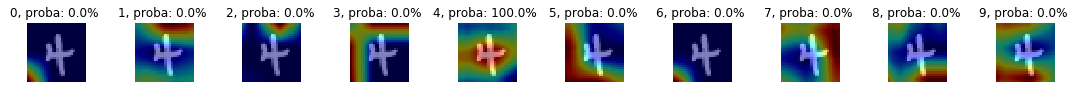

In [14]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(15, 6)
for i in range(10):
    axes[i].set_title(f"{i}, proba: {predicted_probas[0][i]*100}% ")
    axes[i].axis('off')
    axes[i].imshow(x, cmap="gray")
    axes[i].imshow(saliency_maps[i], cmap='jet', alpha=0.5)
    
plt.tight_layout()
plt.show()